In [ ]:
#CONVERCION DE HF TO CP
import pandas as pd
import numpy as np

#What is needed is a spreadsheet where the first two columns are the Temp/reference Cp data
#and the other two columns are the data with more aging: Temp/More_Aged_Cp data 
filename = 'INPUT_PS.xlsx'

#INPUT, as necessary based on the sheet called
sheet = 0

#Loading the data from the Input
data = pd.read_excel(filename, sheet_name=sheet, header=0)

Ncols = 62 

#For FSC Measurements: conversion from HF (IN MILIWATTS) to Cp (HF divided by the cooling rate and the mass)

resultSet = pd.DataFrame()

for col in range(1, Ncols, 2):
    name = data.columns.values[col]
        
    n = col-1
    mass = 1.6e-7 # # in g
    q = -1000 # in K/s
        
    data.iloc[:, col]  = data.iloc[:, col] / (1000 * mass * q) # divided by 1000 to convert to J/g.K   
    
    resultSet[f'T_{name}']  = data.iloc[:-1, n]
    resultSet[f'{name}'] = data.iloc[:-1, col]

resultSet.to_excel(r"C:\Users\...\conversion_HF_TO_CP_PS.xlsx", index=False)


In [ ]:
#DETERMINATION OF TON
import pandas as pd
from scipy.optimize import least_squares
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.integrate import simps
import matplotlib.pyplot as plt
from datetime import datetime

#RUN THIS METHOD TO DETERMINE THE VALUE OF T_ON. FOR THAT USE A VERY AGED SAMPLE.

#What is needed is a spreadsheet where the first two columns are the Temp/reference Cp data
#and the other two columns are the data with more aging: Temp/More_Aged_Cp data 
filename = 'INPUT_PS.xlsx'

#INPUT, as necessary based on the sheet called
sheet = 0

#LOAD DATA FROM INPUT
data = pd.read_excel(filename, sheet_name=sheet, header=0)

#INPUT, these should be the same for one set of aging experiments
#Lower and  Higher bounds of total analysis of the experiment (INPUT), is only to not consider the noisy parts 
L = 465   #Index Lower limit
H = 2650  #Index higher limit

#Tmin and Tmax represent the filter in temperature before and after glass transition
Tmin = 386  #Tmin MUST BE JUST BELOW the glass transition TO OBTAIN PROPERTLY T_ON.
Tmax = 443   #Tmax IS AFTER the glass transition, EXAMPLE Tf + 50K

#Initial values of c and d-> both in zero
c = 0.0
d = 0.0
theta0 = [c, d]

# Slice the data within the range
data = data[L:H+1].reset_index()

#Number of columns to analyze(this case only 4)
Ncols = 4
col = 3

# Aged Cp column of interest INPUT,
m = col + 1;
# Related Temperature should be to the left of Cp data
n = m - 1;

#Initial time for this Method
initTime = datetime.now().time()
initTimeseconds = (initTime.hour * 60 + initTime.minute) * 60 + initTime.second

#Conversion from Celcius to Kelvin. You can change that offset to do another conversion.
tempOffset = 273.15
tempCols = [x for x in range(1, Ncols+1, 2)]
data.iloc[:, tempCols]  = data.iloc[:, tempCols] + tempOffset

#For FSC Measurements: conversion from HF (IN MILIWATTS) to Cp (HF divided by the cooling rate and the mass)
mass = 1.6e-7 # # in g
q = -1000 # in K/s
CpCols = [x for x in range(2, Ncols, 2)] # HF in mW
data.iloc[:, CpCols]  = data.iloc[:, CpCols] / (1000 * mass * q) # divided by 1000 to convert to J/g.K


#a and b represent exact Cp cell values
a = data.iloc[0, m]; #Cp(T=Tini)
b = data.iloc[H - L - 1, m]; #Cp(T=Tend)

# Creation of the variables we want to save
CHI = []
C = []
D = []
TF = []
I = []
DH = []
RUNNINGTime = []
name = data.columns.values[col+1]
I.append(name)

#What is needed is a spreadsheet where the first two columns are the Temp/reference Cp data
#and the remaining are Temp/Aged Cp data in alternating form

# Model used
def modelPoint(o, c, d, Tend, Tini, data, m, n, a, b):
    cp    = data.iloc[o, m]  #cp(T)
        
    DeltaT = Tend - Tini #Delta_T
    coef   = (1.0 - (d / a)) / DeltaT  #  (1- d/Cp(T=Tini)) / Delta_T
    e      = ( coef *  cp + b - Tend * coef ) / b;  # ( coef * cp(T) + Cp(T=Tend) -Tend *coef ) / Cp(T=Tf)

    # Update modified  Cp
    return cp * e + c;        

# Model set    
def modelSet(c, d, data, m, n, a, b):
    # Slope factor      
    Tend     = data.iloc[H - L - 1, n] #(Tend)
    Tini  = data.iloc[0, n]  #(Tinitial)
    
    # Return list generator
    return [modelPoint(o, c, d,  Tend, Tini, data, m, n, a, b) for o in range(0, H - L)]

# Loss function to reduce the influence of outliers. Filter in the temperatures around the transition
def p(o, n, Tmin, Tmax, data):
    return 1.0 if data.iloc[o, n] < Tmin or data.iloc[o, n] > Tmax else 0.0
    
# This method returns the vector of residuals for the given parameters.
# Input: theta[0] is c, and X[1] is d.
def residuals(theta, data, m, n, a, b, Tmin, Tmax):
    c   = theta[0]
    d   = theta[1]

    # Starting values for MSE and DeltaH is by default, 0.
    model = modelSet(c, d, data, m, n, a, b)
    diffs = [0] * len(model)
    
    for o, point in enumerate(model, start=0):
        # This refers to the reference deltaCp that CHANGES WITH THE SAMPLE
        #residual   = point - data.iloc[o, m - 2]
         # This refers to THE SAME REFERENCE deltaCp that would be in the second column
        residual   = point - data.iloc[o, 2]
        diffs[o]   = p(o, n, Tmin, Tmax, data) * residual;
    
    return diffs

def deltaH(c, d, data, m, n, a, b, Tmin, Tmax):
    dH = 0    
    model = modelSet(c, d, data, m, n, a, b)
    for o in range(0, len(model) - 1):
        # residual   = model[o] - data[m - 2][o]
        residual   = model[o] - data.iloc[o, 2]
        inverseP   = 1.0 - p(o, n, Tmin, Tmax, data)
        dH         = dH + inverseP * (residual * (data.iloc[o + 1, n] - data.iloc[o, n]))
    return dH

resultSet = pd.DataFrame({'TRef': data.iloc[:-1, 1], 'CPRef':data.iloc[:-1, 2]})

result = least_squares(residuals, 
                       theta0, # initial guess at starting point
                       args = (data, m, n, a, b, Tmin, Tmax), # alternatively you can do this with closure variables in f if you like
                       ftol=None,
                       gtol=1e-15,
                       xtol=None,
                       max_nfev=200,  #number of iterations to obtain c and d.
                      )

c = result.x[0]
d = result.x[1]
C.append(c)
D.append(d)

resultDf = modelSet(c, d, data, m, n, a, b)    #CP CORRECTED AGED 
CHI.append(sum([x ** 2 for x in result.fun]))  # CALCULATION OF THE CHI SQUARE

# NOW WE DO THE LINEAR FITS OF THE GLASS AND LIQUID CURVES UNTIL WE GET THE OPTIMAL VALUE OF TON
cps = resultDf 
temps = np.array(data.iloc[:-1, n])

# WE START FROM THE ELEMENT 5TH OF ALL OUR DATA
lowerBoundIdx = 5
MaxArea = -np.inf
MinArea = np.inf

TmaxIdx = np.inf
TminIdx = np.inf

for idx, temp in enumerate(temps):
    if temp > Tmax:
        TmaxIdx = min(TmaxIdx, idx)
    if temp > Tmin:
        TminIdx = min(TminIdx, idx)

# WE EVALUATE DIFFERENT VALUES OF TON 
for TonIdx in range(lowerBoundIdx, TminIdx):    
    x = np.array(temps[:TonIdx]).reshape(-1, 1)
    y = np.array(cps[:TonIdx])        
    model = LinearRegression().fit(x, y) #LINEAR FIT OF THE GLASS FOR T<TON AND THEN EXTENDED
    
    x = np.array(temps[TonIdx:TmaxIdx])
    y = np.array(cps[TonIdx:TmaxIdx])    
    IcpRight = simps(y, x)   # INTEGRAL CP CORRECTED
    
    x0   = np.array(temps[TonIdx:TmaxIdx])
    x0_t = x0.reshape(-1, 1)
    IinfRight = simps(model.predict(x0_t), x0)       
    
    AreaCpRight = abs(IcpRight - IinfRight) #INTEGRAL CP WITH RESPECT TO GLASS CURVE FROM TON TO TMAX
    
    x = np.array(temps[:TonIdx])
    y = np.array(cps[:TonIdx])    
    IcpLeft = simps(y, x)   # INTEGRAL CP CORRECTED BELOW TON
    
    x0   = np.array(temps[:TonIdx])
    x0_t = x0.reshape(-1, 1)
    IinfLeft = simps(model.predict(x0_t), x0)   # INTEGRAL LINEAR FIT GLASS BELOW TON    
    
    AreaCpLeft = abs(IcpLeft - IinfLeft) #INTEGRAL CP WITH RESPECT TO GLASS CURVE
    
    
    if MaxArea < AreaCpRight:   #OBTAIN THE MAXIMAL INTEGRAL FOR T > TON
        MaxArea = AreaCpRight
        MaxTonIdx = TonIdx 
        
    if MinArea > AreaCpLeft:    #OBTAIN THE MINIMAL INTEGRAL FOR T < TON
        MinArea = AreaCpLeft
        MinTonIdx = TonIdx
    
print(temps[MaxTonIdx])   #OBTAINED TON METHOOD 1
print(temps[MinTonIdx])   #OBTAINED TON METHOOD 2

C:\Users\Anabella\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\Anabella\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\Anabella\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\Anabella\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\Anabella\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\Anabella\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prim

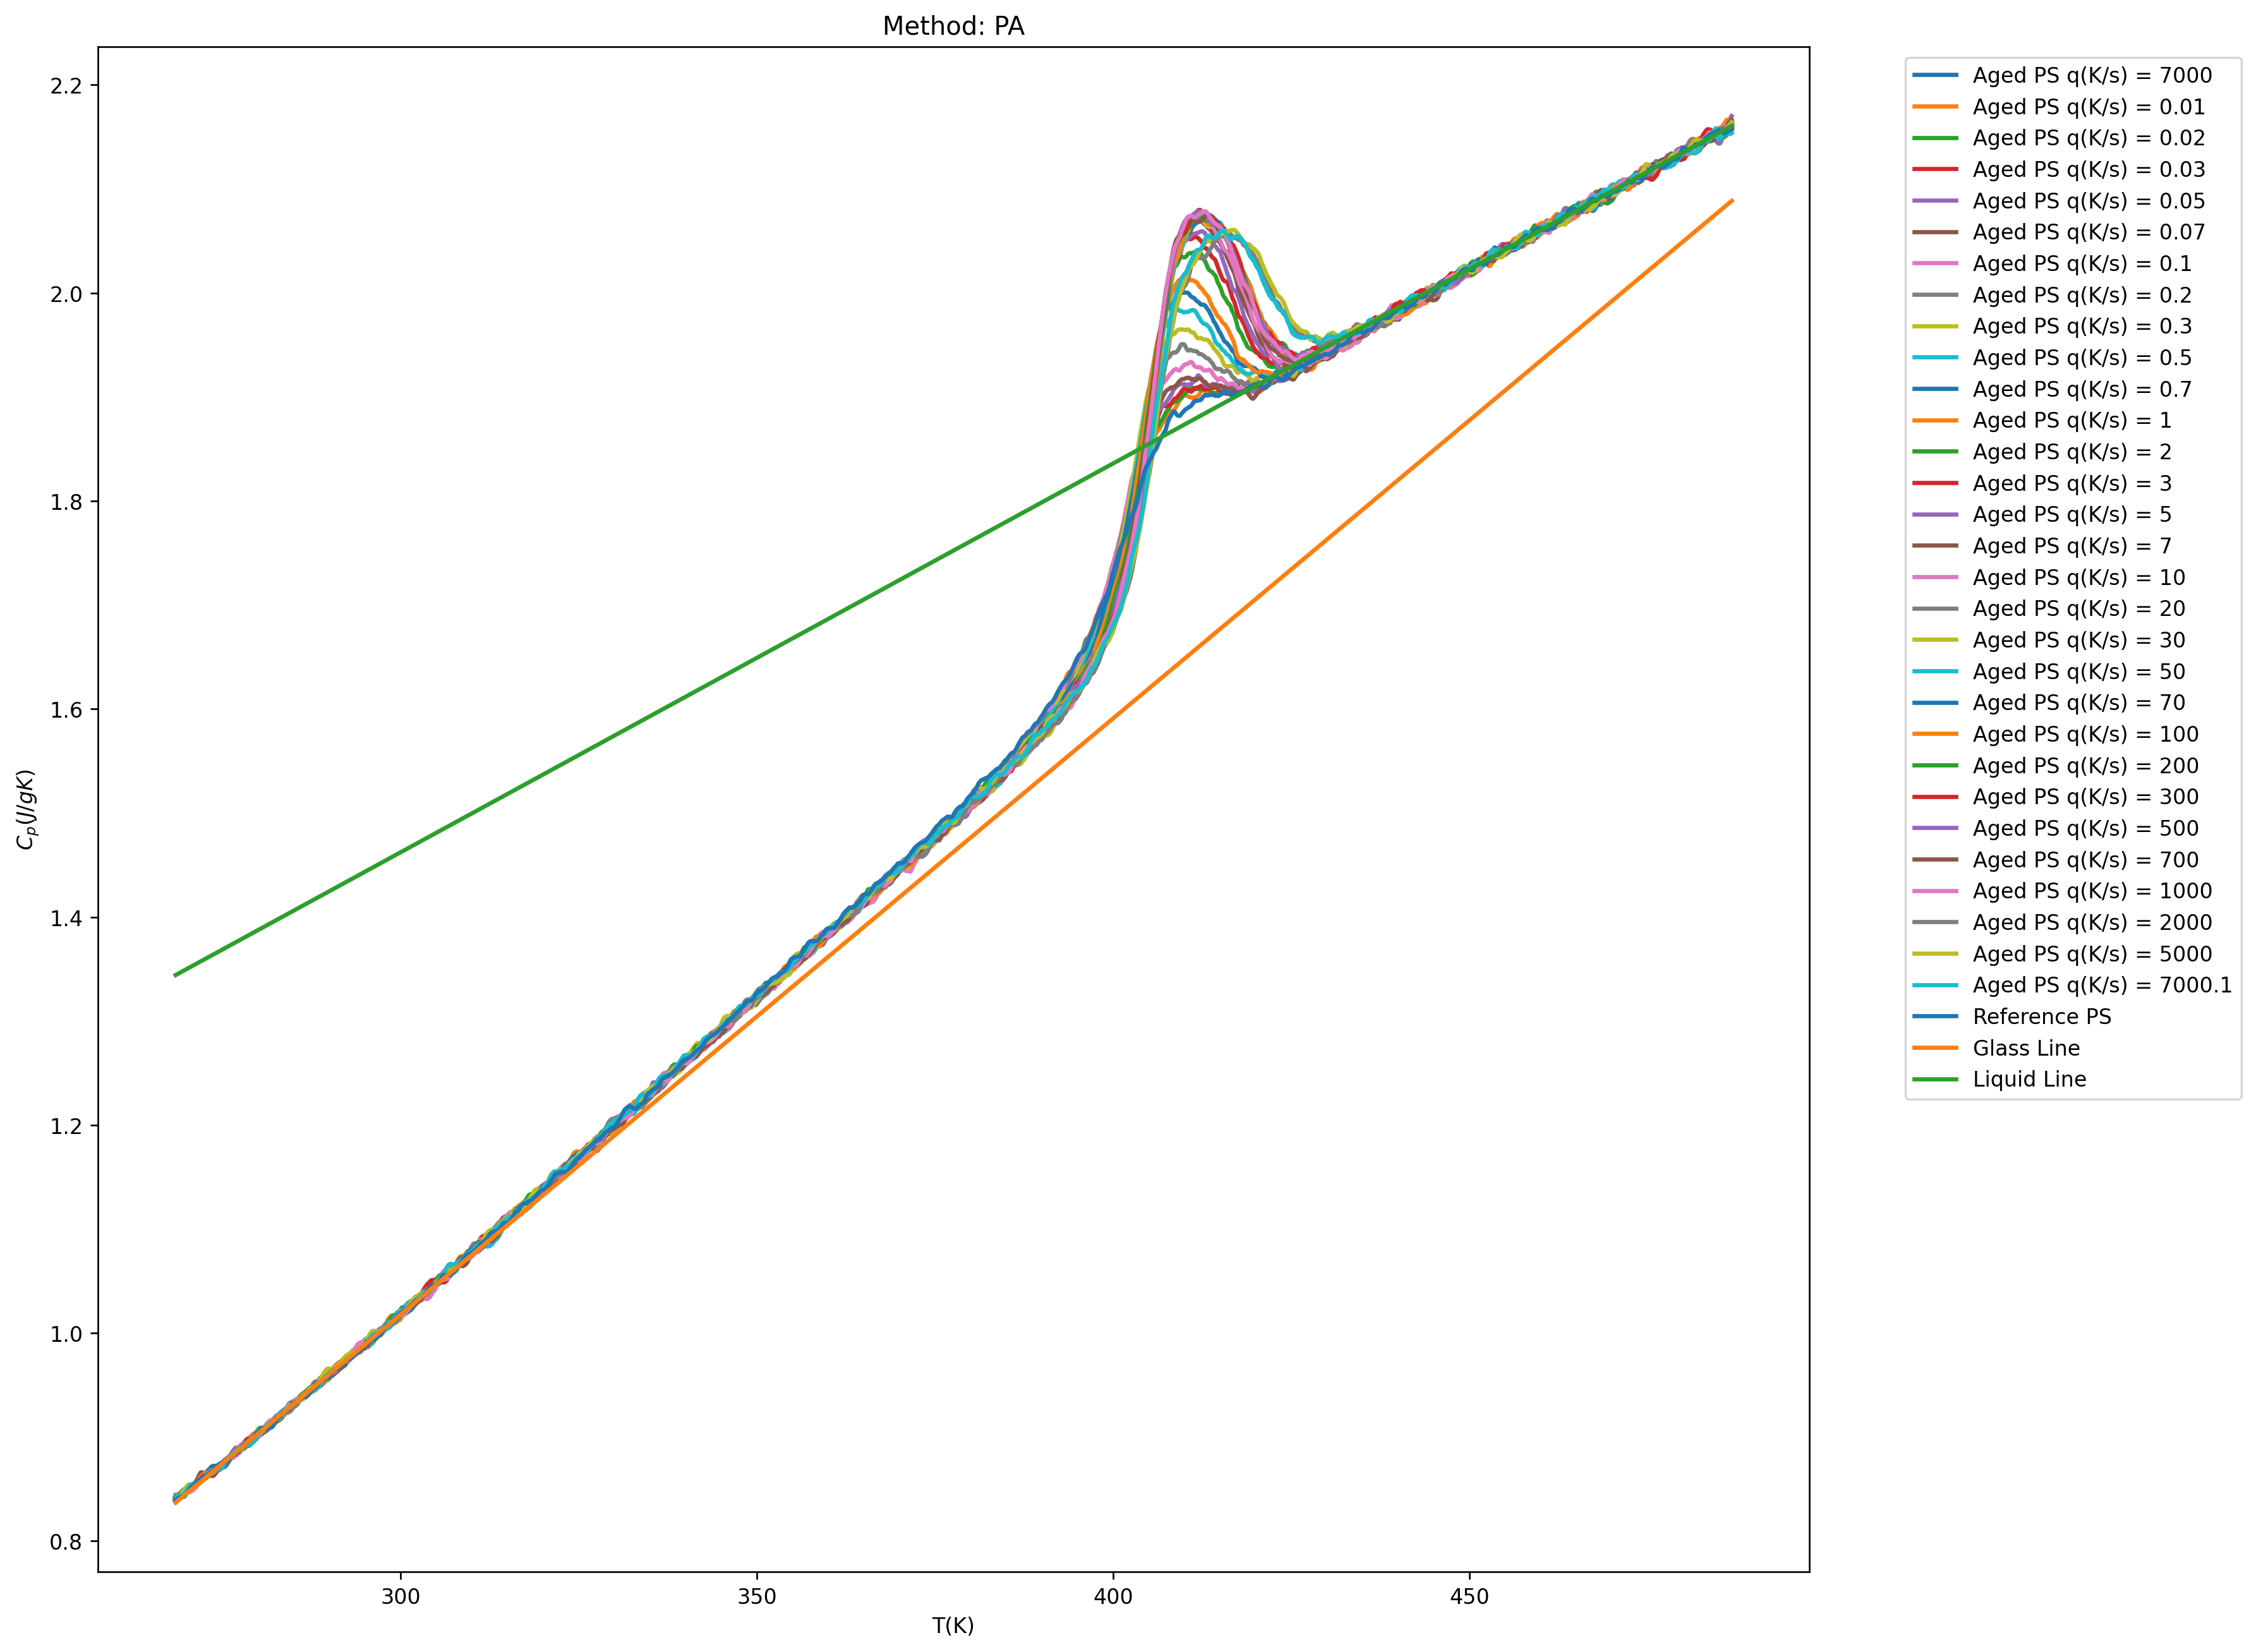

In [10]:
#MAIN CODE TO ANALYZE THE FSC DATA
import pandas as pd
from scipy.optimize import least_squares
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.integrate import simps
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.pyplot import figure

#What we need is an Excel Spreadsheet where the first two columns are the Temperature and the  
#Cp of the Reference and the remaining columns are Temperature and the Cp of the age samples.
#The Input file is T_Ref/Cp_Ref/T_Aged/Cp_Aged/.../T_Aged/Cp_Aged
#The first line is the Header and this program will save that name in the Output, so it's important to define it
filename = 'INPUT_PS.xlsx'

#INPUT, as necessary based on the sheet called
sheet = 0

#Loading the data from the Input
data = pd.read_excel(filename, sheet_name=sheet, header=0)

#Select the Lower and  Higher Row Limit of the Experiment
#These should be the same for one set of aging experiments (reference and aged samples)
L = 465   #Index Lower limit
H = 2650  #Index higher limit

#Select the Limits in Temperature (in K) where the glass transition occurs
Tmin = 280   #Tmin: Lower Limit: here you can use the TON obtained from the other method. If not, select a value  far below the transition
Tmax = 445   #Tmax: Upper Limit after the glass transition
Tglass = 310 #Tglass: Is the maximal T where ends the glass line by eye
Tmelt = 440  #Tmelt: Is the minimal T where starts the liquid line by eye


#Initial seeds for the values of c (or a) and d (or b)-> initially both in zero
c = 0.0
d = 0.0
theta0 = [c, d]

# Slice the data within the Selected Range
data = data[L:H+1].reset_index()

#Number of columns to analyze (start to count from 1): number of aged experiments to analyze  
Ncols = 62 

#Conversion from Celsius to Kelvin (if needed), else set  tempOffset to zero.
tempOffset = 273.15
tempCols = [x for x in range(1, Ncols+1, 2)]
data.iloc[:, tempCols]  = data.iloc[:, tempCols] + tempOffset

# Creation of the variables we want to save
CHI = [] #Error
C = []   #c
D = []   #d
TF = []  #Fictive Temperature
I = []   #Name of each column
DH = []  #Recovery Entalpy
RUNNINGTime = []  #Time

#CONVERTION OF THE HF DATA TO CP (if needed)
#For FSC Measurements: conversion from HF (IN MILIWATTS) to Cp (HF divided by the cooling rate and the mass)
mass = 1.6e-7 # # in g
q = -1000 # in K/s
CpCols = [x for x in range(2, Ncols, 2)] # HF in mW
data.iloc[:, CpCols]  = data.iloc[:, CpCols] / (1000 * mass * q) # divided by 1000 to convert to J/g.K
   
# Model used
def modelPoint(o, c, d, Tend, Tini, data, m, n, a, b):
    cp    = data.iloc[o, m]  #cp(T)
        
    DeltaT = Tend - Tini #Delta_T
    coef   = (1.0 - (d / a)) / DeltaT  #  (1- d/Cp(T=Tini)) / Delta_T
    e      = ( coef *  cp + b - Tend * coef ) / b;  # ( coef * cp(T) + Cp(T=Tend) -Tend *coef ) / Cp(T=Tf)

    # Update modified  Cp
    return cp * e + c;        

# Model set    
def modelSet(c, d, data, m, n, a, b):
    # Slope factor      
    Tend     = data.iloc[H - L - 1, n] #(Tend)
    Tini  = data.iloc[0, n]  #(Tinitial)
    
    # Return list generator
    return [modelPoint(o, c, d,  Tend, Tini, data, m, n, a, b) for o in range(0, H - L)]

# Loss function. Filter for Temperatures around the glass transition
def p(o, n, Tmin, Tmax, data):
    return 1.0 if data.iloc[o, n] < Tmin or data.iloc[o, n] > Tmax else 0.0
    
# This method returns the vector of residuals for the given parameters.
def residuals(theta, data, m, n, a, b, Tmin, Tmax):
    c   = theta[0]
    d   = theta[1]

    # Starting values for MSE and DeltaH is by default, 0.
    model = modelSet(c, d, data, m, n, a, b)
    diffs = [0] * len(model)
    
    for o, point in enumerate(model, start=0):
        # This refers to the reference deltaCp that CHANGES WITH THE SAMPLE
        #residual   = point - data.iloc[o, m - 2]
         # This refers to THE SAME REFERENCE deltaCp that would be in the second column
        residual   = point - data.iloc[o, 2]
        diffs[o]   = p(o, n, Tmin, Tmax, data) * residual;
    
    return diffs

# Calculation of the recovered enthalpy
def deltaH(c, d, data, m, n, a, b, Tmin, Tmax):
    dH = 0    
    model = modelSet(c, d, data, m, n, a, b)
    for o in range(0, len(model) - 1):
        # residual   = model[o] - data[m - 2][o]
        residual   = model[o] - data.iloc[o, 2]
        inverseP   = 1.0 - p(o, n, Tmin, Tmax, data)
        dH         = dH + inverseP * (residual * (data.iloc[o + 1, n] - data.iloc[o, n]))
    return dH

resultSet = pd.DataFrame({'TRef': data.iloc[:-1, 1], 'CPRef':data.iloc[:-1, 2]})

# TO SAVE A FIGURE OF ALL THE ANALYZED DATA: creation of the figure with size and resolution
figure(figsize=(15, 11), dpi=240) 

# Now we start the analysis of all the measurements (starting from the 4th column until all the aged experiments)
for col in range(3, Ncols, 2):
    # Initial time
    initTime = datetime.now().time()
    initTimeseconds = (initTime.hour * 60 + initTime.minute) * 60 + initTime.second  
    
    # Initial Cp_Aged in the m column, for the particular aging time you desire
    m = col + 1;
    # Related Temperature should be to the left of Cp data
    n = m - 1;
    
    #name = data.columns.values[col+1].replace("/", "-")
    name = data.columns.values[col+1]
    I.append(name)   
    
    #a and b represent exact Cp cell values
    a = data.iloc[0, m]; #Cp(T=Tini)
    b = data.iloc[H - L - 1, m]; #Cp(T=Tend)
    
    # Least Square fitting to find c and d
    result = least_squares(residuals, 
                           theta0, # initial guess at starting point
                           args = (data, m, n, a, b, Tmin, Tmax), # alternatively you can do this with closure variables in f if you like
                           ftol=None,
                           gtol=1e-15,
                           xtol=None,
                           max_nfev=200,  #number of iterations to obtain c and d.
                          )
    
    c = result.x[0]
    d = result.x[1]
    C.append(c)
    D.append(d)

    resultDf = modelSet(c, d, data, m, n, a, b)    #CP CORRECTED
    CHI.append(sum([x ** 2 for x in result.fun]))  # CALCULATION OF THE MSE

    # Now we calculate the linear fits for the glass and the liquid state
    #Linear fit of the glassy state for  T<Tglass
    x = []
    for o in range(0, H - L):
        temp = data.iloc[o, 1]
        if temp > Tglass:
            break
        x.append(data.iloc[o, 1])
        
    x = np.array(x).reshape(-1, 1)
    y = np.array(data.iloc[0:len(x), 2])  
    model = LinearRegression().fit(x, y) #LINEAR FIT OF THE GLASS FOR T<Tglass AND THEN EXTENDED
    
    #Linear fit of the liquid state for  T>Tmelt
    x = []
    for o in range(0, H - L):
        temp = data.iloc[o, 1]
        if temp > Tmelt:
            x.append(data.iloc[o, 1])
            
    x1 = np.array(x).reshape(-1, 1)
    y1 = np.array(data.iloc[H-L-len(x1)+1:, 2]) #np.array(data.iloc[H-L-len(x1):len(x1), 2])  
    model1 = LinearRegression().fit(x1, y1)  #LINEAR FIT OF THE LIQUID FOR T>TMAX AND THEN EXTENDED

    # Now we calculate the integrals to determine Tf using the matching areas 
    x = []
    iTmax = -1
    iTmin = H-L
    for o in range(0, H - L):
        temp = data.iloc[o, n]
        if temp < Tmelt and temp > Tglass:
            x.append(temp)
            iTmax = max(iTmax, o)
            iTmin = min(iTmin, o)
   
    # Integral of Cp corrected
    x = np.array(x)
    y = np.array(resultDf[iTmin:iTmax+1])
    Icp = simps(y, x)   
    
    # Integral of the glassy curve
    x0   = np.array(data.iloc[iTmin:iTmax+1, 1])
    x0_t = x0.reshape(-1, 1)

    Iinf = simps(model.predict(x0_t), x0)   

    # Integral of the liquid curve
    x0   = np.array(data.iloc[iTmin:iTmax+1, 1])
    x0_t = x0.reshape(-1, 1)
    
    Isup = simps(model1.predict(x0_t), x0)
        
    # Integral of Cp corrected with respect of the glassy curve from Tmin to Tmax
    AreaCp = Icp - Iinf 

    diff = float("inf")
    bestTf = 0

    #The error in Tf depends of this discretization of this variation. IN THIS CASE: 0.005
    for Tf in np.arange(Tmin, Tmax, 0.005): #HERE WE VARY TF AND CALCULATE THE AREAS TO OBTAIN THE TF WHERE THEY MATC
        x0   = np.array(np.arange(Tf, Tmax, 0.1))
        x0_t = x0.reshape(-1, 1)

        Isup2 = simps(model1.predict(x0_t), x0)
        Iinf2 = simps(model.predict(x0_t), x0)
        
        #Now we determine the value of Tf according to the matching areas   
        #Here we minimize Eqn. 7
        if abs(Isup2 - Iinf2 - AreaCp) < diff:
            diff = abs(Isup2 - Iinf2 - AreaCp) 
            bestTf = Tf  
            #Values of Tf that minimized Eqn. 7  
        
    TF.append(bestTf)
       
    DH.append(deltaH(c, d, data, m, n, a, b,Tmin, Tmax))
     
    #End Time    
    endTime = datetime.now().time()
    endTimeseconds = (endTime.hour * 60 + endTime.minute) * 60 + endTime.second
    totalTime = endTimeseconds - initTimeseconds   
    RUNNINGTime.append(totalTime)
    
    #Calculation of Delta Cp 
    differencia = resultDf - data.iloc[:-1, 2]
    
    #Saving the Corrected Cp and Delta Cp 
    resultSet[f'TCor_{name}(K)']  = data.iloc[:-1, n]
    resultSet[f'CPCor_{name}(J/gK)'] = resultDf
    resultSet[f'DeltaCp_{name}(J/gK)'] = differencia
  
    #Plotting the Corrected Cp for each aged column. If you don't want to plot comment this lines (the program will be faster)
    plt.grid()
    plt.plot(data.iloc[:-1, 1], resultDf,  linewidth=2, label=f'Aged PS q(K/s) = {name}')  # plot all Cp(T) corrected
    x0 = np.array(data.iloc[:-1, n]).reshape(-1, 1)
    plt.xlabel('T(K)')
    plt.ylabel('$C_p (J/g K)$') 

#Continuation of the same plot with the Reference and the liquid and glass lines        
plt.plot(data.iloc[:-1, 1], data.iloc[:-1, 2], linewidth=2, label='Reference PS') # cp reference ONLY ONE REFERENCE  
x0 = np.array(data.iloc[:-1, n]).reshape(-1, 1)
plt.plot(x0, model.predict(x0), linewidth=2, label='Glass Line')  #glassy state fit
plt.plot(x0, model1.predict(x0), linewidth=2, label='Liquid Line' )  #liquid state fit
plt.title("Method: PA") #title of the plot
plt.xlabel('T(K)') #name of x-axes
plt.ylabel('$C_p (J/g K)$') #name of y-axes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  #location of the legand
plt.tight_layout()

#Name and location of the output figure to be saved     
plt.savefig(f"C:/Users/.../CP_CORR_PS.png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()   #Here we show the graph 

#Location of the outpit Excel file for the corrected Cp and Delta Cp vs T
resultSet.to_excel(f"C:/Users/.../CP_CORR_PS.xlsx", index=False)
            
#Saving all the calculated parameters
resultSet = pd.DataFrame({'v(K/s) or t(s)': I[:], 'c': C[:], 'd': D[:], 'MSE': CHI[:], 'Tf(K)': TF[:], 'Dh(J/g)': DH[:],'running_time(s)': RUNNINGTime[:]})

#Location of the outpit Excel file for all the calculated parameters
resultSet.to_excel(r"C:\Users\...\RESULT_PS.xlsx", index=False)

# Plotting Results 
#plt.plot(data.iloc[:-1, n], resultDf) #cp new corrected 
#plt.plot(data.iloc[:, m-3], data.iloc[:, m-2]) # cp reference
#plt.plot(data.iloc[:-1, 1], data.iloc[:-1, 2])# cp reference
#plt.plot(data.iloc[:, n], data.iloc[:, m])  # cp aged original


#x0 = np.array(data.iloc[:-1, n]).reshape(-1, 1)
#plt.plot(x0, model.predict(x0))  #glassy state fit
#plt.plot(x0, model1.predict(x0))  #liquid state fit
#plt.show()

#Delta cp
#plt.plot(data.iloc[:-1, 1], differencia) 
#plt.show()

In [ ]:
#METHOD TO INCLUDE NOISE

import numpy as np
import matplotlib.pyplot as plt
import statistics

Ref_watts = data.iloc[:-1, 2]  ** 2
#resultDf_watts = [x ** 2 for x in resultDf]
Aged_watts = data.iloc[:-1, 4]  ** 2
# resultDf_watts = resultDf * resultDf

Ref_dB = 10 * np.log10(Ref_watts)
resultDf_dB = 10 * np.log10(resultDf_watts)
plt.plot(data.iloc[:-1, 1], Ref_dB)
plt.plot(data.iloc[:-1, n], resultDf_dB)
plt.show()

# Calculate signal power and convert to dB 
ref_avg_watts = np.mean(Ref_watts)
sig_avg_watts = np.mean(resultDf_watts)

sig_avg_db_ref = 10 * np.log10(ref_avg_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)

mean_noise = 0

Delta_resultDf = resultDf[iTmax]  - resultDf[iTmin] 

# Set a target SNR
target_snr_db = 16

# Calculate noise  then convert to watts
noise_avg_db_ref = sig_avg_db_ref - target_snr_db
noise_avg_db = sig_avg_db - target_snr_db

noise_avg_ref = 10 ** (noise_avg_db_ref / 10)
noise_avg = 10 ** (noise_avg_db / 10)

# Generate an sample of white noise
noise_ref = np.random.normal(mean_noise, np.sqrt(noise_avg_ref), len(resultDf_watts))
noise = np.random.normal(mean_noise, np.sqrt(noise_avg), len(resultDf_watts))

# Noise up the original signal
Ref_noise = data.iloc[:-1, 2]  + noise_ref
resultDf_noise = resultDf + noise

# calculation delta noise
mean_noise_ref = 3 * statistics.stdev(noise_ref)
mean_noise = 3 * statistics.stdev(noise)

delta_noise_ref = mean_noise_ref/Delta_resultDf
delta_noise = mean_noise/Delta_resultDf

# print(mean_noise_ref)
# print(Delta_resultDf)
# print(delta_noise_ref)
print(delta_noise)

plt.plot(data.iloc[:-1, n], resultDf_noise)
plt.plot(data.iloc[:-1, 1], Ref_noise)
plt.show()

resultSet1 = pd.DataFrame({'TRef': data.iloc[:-1, 1], 'CPRef_noise':Ref_noise, 'TCorr': data.iloc[:-1, n], 'CPCorr_noise':resultDf_noise})
resultSet1.to_excel(f"C:/Users/.../noise_1.xlsx", index=False)